# Problem 1, 5300 Final: Double Pendulum
## Author: Aidan Snyder, 4/28/23

The goal of this notebook is to complete problem 1 of the physics 5300 Spring 2023 final, which is solve numerically a double pendulum system. I will be using the Lagrangian method to do so, and the equations which need to be addressed are:  

$U(\phi_1, \phi_2) = (m_1 + m_2) g L_1 (1 - \cos{\phi_1}) + m_2 g L_2 (1 - \cos{\phi_2})$ (11.37)  
$T(\phi_1, \phi_2) = \frac{1}{2}(m_1+m_2)L^2\dot{\phi_1}^2 + m_2 L_1 L_2 \dot{\phi_1}^2\dot{\phi_2}^2 \cos(\phi_1 - \phi_2) + \frac{1}{2}m_2 L_2^2 \dot{\phi_2}^2$ (11.38)

After a lot of solving and moving variables around, and renaming them so that they can fit into python's ODE solver, we are left with:

$c, s = \cos(\theta_1 - \theta_2), \sin(\theta_1 - \theta_2)$  
$c_1, s_1 = \cos(\theta_1), \sin(\theta_1)$  
$c_2, s_2 = \cos(\theta_2), \sin(\theta_2)$  
${d} = ({m_1} + {m_2}  s^2)$  

$\theta_1^{\prime} = z_1$  
$z_1^{\prime} = \frac{L_1}{\text{d}}  ({m_2}  {g}  s_2  c - {m_2}  s  ({L_1}  z_1^2  c + {L_2}  z_2^2) - ({m_1} + {m_2})  {g}  s_1)$  
$\theta_2^{\prime} = z_2$  
$z_2^{\prime} = \frac{L_2}{\text{d}}  (({m_1} + {m_2})  ({L_1}  z_1^2  s - {g}  s_2 + {g}  s_1  c) + {m_2}  {L_2}  z_2^2  s  c)$  

These are the equations that are turned into code in the MyDoublePendulum class.

In [1]:
%matplotlib inline

In [11]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from IPython.display import Image

plt.rcParams['figure.dpi'] = 100.
# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [14]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg')

In [3]:
class MyDoublePendulum():
    '''
    MyDoublePendulum is a class which solves the Euler-Lagrange equation for a double pendulum system
    without resorting to a small angle approximation.
    
    Parameters:
    L1: Length of pendulum 1
    L2: Length of pendulum 2
    m1: Mass of pendulum bob 1
    m2: Mass of pendulum bob 2
    
    Methods:
    dy_dt(t,y)
        returns the RHS of the differential equation for vector y
    solve_ode()
        solves the system of differential equations, and records the EOM's
    '''
    
    def __init__(self, L1=1., L2=1., m1=1., m2=1., g=1.):
        self.L1 = L1
        self.L2 = L2
        self.m1 = m1
        self.m2 = m2
        self.g = g
        
    def dy_dt(self, t, y):
        
        theta1, z1, theta2, z2 = y
        c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)
        c1, s1 = np.cos(theta1), np.sin(theta1)
        c2, s2 = np.cos(theta2), np.sin(theta2)
        denominator = (self.m1 + self.m2 * s**2)
        
        theta1_dot = z1
        
        z1_dot = (self.m2 * self.g * s2 * c - self.m2 * s * (self.L1 * z1**2 * c + self.L2 * z2**2) \
                    - (self.m1 + self.m2) * self.g * s1) / self.L1 / denominator
        theta2_dot = z2
        
        z2_dot = ((self.m1 + self.m2) * (self.L1 * z1**2 * s - self.g * s2 + self.g * s1 * c) \
                     + self.m2 * self.L2 * z2**2 * s * c) / self.L2 / denominator
        
        return theta1_dot, z1_dot, theta2_dot, z2_dot
    
    def solve_ode(self, t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        
        y = [theta1_0, theta1_dot_0, theta2_0, theta2_dot_0]
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y, t_eval = t_pts,
                            atol = abserr, rtol = relerr)
        theta1, theta1_dot, theta2, theta2_dot = solution.y
        
        return theta1, theta1_dot, theta2, theta2_dot
    

In [4]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [6]:
t_start = 0.
t_end = 50.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 



In [7]:
theta1_0 = np.pi/2
theta2_0 = np.pi
theta1_dot_0=0.
theta2_dot_0=0.
L1=1.
L2=1.
m1=1.
m2=1.
g=1.

p1 = MyDoublePendulum(L1=L1, L2=L2, m1=m1, m2=m2, g=g)
theta1, theta1_dot, theta2, theta2_dot = \
        p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)


(<AxesSubplot:xlabel='$t$', ylabel='$\\theta(t)$'>,
 <matplotlib.lines.Line2D at 0x7f8b77717850>)

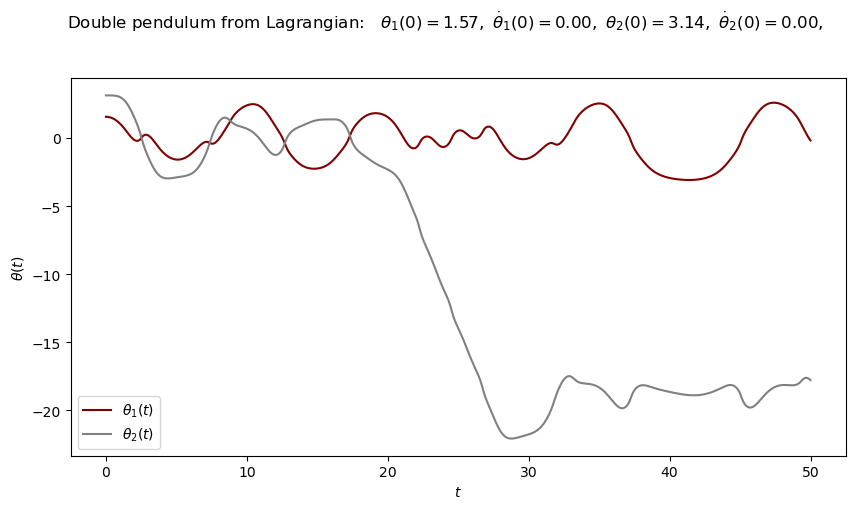

In [8]:
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')
fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'

fig.suptitle(overall_title, va = 'baseline')

ax_a = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
plot_y_vs_x(t_pts[start:stop], theta1[start:stop],
            axis_labels = theta_vs_time_labels, color = 'maroon', label = r'$\theta_1(t)$', ax=ax_a)
plot_y_vs_x(t_pts[start:stop], theta2[start:stop],
            axis_labels = theta_vs_time_labels, color = 'gray', label = r'$\theta_2(t)$', ax=ax_a)

### Chaos Test
Now, we will test to see if the system is actually chaotic. To do this, we will instantiate two double pendulum systems, both with very nearly the same initial conditions, but with the starting angle for one of the pendulums slightly different than its counterpart. If this system were not chaotic, this tiny change would have almost no effect on the system as a whole, but as we will see, for chaotic systems, this makes a substantial difference to the long term behavior of the double pendulum system.

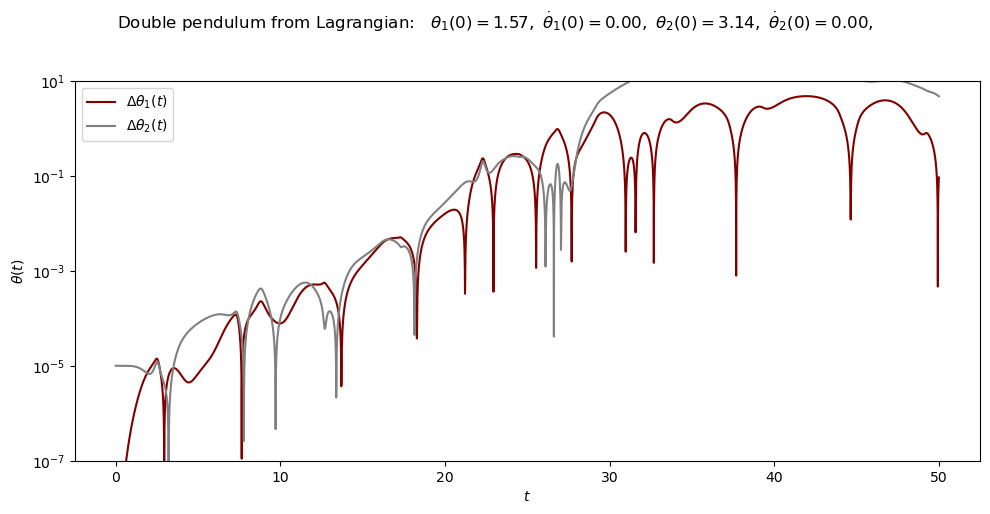

In [10]:
theta1_0 = np.pi/2
theta2_0 = np.pi
theta1_dot_0=0.
theta2_dot_0=0.

theta1, theta1_dot, theta2, theta2_dot = \
        p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0, theta2_dot_0)
theta1b, theta1_dotb, theta2b, theta2_dotb = \
        p1.solve_ode(t_pts, theta1_0, theta1_dot_0, theta2_0 - 0.00001, theta2_dot_0)

fig = plt.figure(figsize=(10,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\theta_1(0) = {theta1_0:.2f},$' + \
                rf' $\dot\theta_1(0) = {theta1_dot_0:.2f},$' + \
                rf' $\theta_2(0) = {theta2_0:.2f},$' + \
                rf' $\dot\theta_2(0) = {theta2_dot_0:.2f},$'

fig.suptitle(overall_title, va = 'baseline')

ax_a = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)

plot_y_vs_x(t_pts[start:stop], np.abs(theta1[start:stop] - theta1b[start:stop]),
            axis_labels = theta_vs_time_labels, color = 'maroon',
            semilogy=True, label = r'$\Delta\theta_1(t)$', ax=ax_a)

plot_y_vs_x(t_pts[start:stop], np.abs(theta2[start:stop] - theta2b[start:stop]),
            axis_labels = theta_vs_time_labels, color = 'gray',
            semilogy=True, label = r'$\Delta\theta_2(t)$', ax=ax_a)

ax_a.set_ylim(1.e-7,10.)
fig.tight_layout()

So as we can see, over time the difference between the angles of the nearly identically set up double pendulum systems grows substantially over time. Therefore, we can confidently say that this system is indeed chaotic.